# Libri speech Classification baseline: PyBrain Neural Network

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

# General
import sys 
import os
from os import path, makedirs
import shutil
import numpy as np 
import pandas as pd

sys.path.insert(0, '../../Utils')
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# For PyBrain approach  
import speech_recognition as sr   # pip install SpeechRecognition.
from pybrain.datasets                import ClassificationDataSet
from pybrain.supervised.trainers     import BackpropTrainer
from pybrain.tools.customxml.networkreader import NetworkReader
from pybrain.tools.customxml.networkwriter import NetworkWriter

#visualization imports:
import matplotlib.pyplot as plt
%matplotlib inline

#audioviz
import librosa as lr
import IPython.display

print("Python: %s" % sys.version)

Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]


## Data parameters

In [2]:
# Frames and frequencies
durationCheck = 10.      # Only consider files with 10 or more seconds of audio.
deltaT        = 0.2      # Audio frame size is 0.2 seconds.
noisy         = 0.1      # This sets the limit for static, i.e. pauses in speech.
lim1 = 10; lim2 = 410    # Lower and upper frequencies. 
                         # For the above parameters and 16 kHz sampling, this range is about 50 - 2000 Hz. 
# Path names   
audioType  = ".flac"               # Flac files. 
datapath   = "data/LibriSpeech/"        # Path where audio files are located.
trainSet   = "train-speakerID/"        # Training set.
cvSet      = "cv-speakerID/"           # Cross-Validation set.
tstSet     = "test-speakerID/"         # Test set. 
stem       = "nn"                  # Output network filename stem.    

numSpeakers = 10 #make this an even #

if numSpeakers == 10:
    # These are the speakers.
    # Female: 19, 32, 39, 40, 83
    # Male: 26, 27, 78, 405, 196
    speakers = ["19/",
                "26/",
                "32/",
                "27/",
                "39/",
                "78/",
                "40/",
                "405/", 
                "83/",
                "196/"]

maxminFile = "min_max_values" + str(numSpeakers) + ".dat"  # File to store max and min values for each frequency bin.
outfolder  = "networks" + str(numSpeakers) + "/"           # Folder to store trained networks.

if not os.path.isdir(outfolder):
    os.mkdir(outfolder)

numFeatures = lim2-lim1

## Only set to True if visualizing previously trained and tested models:

pre_trained = True 


## Hyperparameters

In [3]:
possibleOutputs   = 1       # Only 1 kind of output, i.e. each sample is one speaker.
numHiddenNodes    = 10      # Nodes per hidden layer.
numHiddenLayers   = 5       # 5 layers.
numTrainingEpochs = 0      # Train 'n' epochs.

## Training settings

In [4]:
first = True            # Set up a network.
first = False            # We already have a network.
nnFile = "nn24.xml"      # Most recent. Starting file name to read from.
st = 25                  # Starting file to write to.

#CV settings

if numSpeakers == 10:
    lastN = 79 #the last network there is an XML file for in the networks directory
    firstN = 60 #first network to start with
    
elif numSpeakers == 100:

    lastN = 24 #the last network there is an XML file for in the networks directory
    firstN = 5 #first network to start with

## Download & Extract LibriSpeech data set

In [5]:
#all the code for data loading that isn't needed for visualization:
from LS_UTILS import Data_load
Data_load._download_and_preprocess_data('data/')

Found archive "data/train-clean-100.tar.gz" - not downloading.
Found archive "data/train-clean-360.tar.gz" - not downloading.
Found archive "data/dev-clean.tar.gz" - not downloading.
Found archive "data/dev-other.tar.gz" - not downloading.
Found archive "data/test-clean.tar.gz" - not downloading.
Found archive "data/test-other.tar.gz" - not downloading.
Extracting librivox data if not already extracted...


## Listen to data sample

In [6]:
filename = 'data/LibriSpeech/test-speakerID/1246/124548/1246-124548-0026.flac'
#     # Read in the signal and sample rate
s0, sample_rate = lr.core.load(filename, sr=None, mono=True)
IPython.display.display(IPython.display.Audio(data=s0, rate=sample_rate))

## Load speaker metadata and select speakers

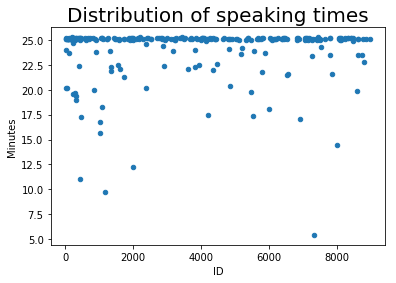

In [7]:
#1. load data from text to pandaframe

# Note: before running this, change 
# 60   | M | train-clean-100  | 20.18 | |CBW| Simon
# to
# 60   | M | train-clean-100  | 20.18 | CBW Simon
df = pd.read_table('data/LibriSpeech/SPEAKERS.TXT',header = 11,sep = '|')
df.columns = ['ID','sex','subset','Minutes','name']
train25 = df[df['subset']== ' train-clean-100  ']
train25.plot.scatter('ID','Minutes')
plt.title('Distribution of speaking times',size = 20);

In [8]:
# 2. Pick a gender balanced group of speakers w/long speaking times
if numSpeakers != 10:
    train25 = train25[train25['minutes'] >= 25]
    print('# potential speakers:',len(train25))

    df_speaker = train25[train25['sex']==' M '][0:numSpeakers//2]
    df_speaker = df_speaker.append(train25[train25['sex']==' F '][0:numSpeakers//2]).sort_index()

    speakers = df_speaker['id'].values
    speakers = [str(i)+'/' for i in speakers]

## Split data from individual speakers into 60% training, 20% test, 20% cross-validation folders

In [9]:
#all the code for data splitting that isn't needed for visualization:
from LS_UTILS import Move_data
Move_data.main(speakers,datapath,trainSet,cvSet,tstSet)

## Load training data for neural network

  below ~15 cells adapted from https://github.com/aravindnatarajan/SpeakerRecognition

  Speaker Identification. Data comes from http://www.openslr.org/12/
  
  Task: Given 't' seconds of speech, identify the speaker.
  
  Training on about 10 minutes of speech per speaker.

In [10]:
#all the code for networks that isn't needed for visualization:
from LS_UTILS import Network_funcs

In [ ]:
# Get data,
# as well as locations where speaker 'i' ends, and speaker 'j' begins.
trnX,trnY,trnIdx = Network_funcs.getDataSpeakers(trainSet,speakers,datapath,audioType,durationCheck,deltaT,lim1,
                                                 lim2,numFeatures,noisy)  

In [ ]:
print('Xdim,ydim',np.shape(trnX), np.shape(trnY)    )
trnRows = np.shape(trnX)[0]

In [ ]:
# Make some plots.
# Frequency index from 0...400 represent a range from 50 - 2000 Hz.
# Time index from 0 to 150 represent a range from 0 - 30 seconds.
plt.title("Speaker #1 (ID# 19/, Female), 30 seconds")
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.imshow(trnX[trnIdx[0]:trnIdx[0]+150,:].T,origin="lower",aspect=0.3);

In [ ]:
plt.title("Speaker #2 (ID# 26/, Male), 30 seconds")
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.imshow(trnX[trnIdx[1]:trnIdx[1]+150,:].T,origin="lower",aspect=0.3);

## Normalize data

In [ ]:
if not pre_trained:

    # Find min and max values for each frequency bin using Training data only.
    # Normalize data to lie in the range (0,1).
    minArray = []; maxArray = []
    for i in range(0,numFeatures):
      minArray.append(np.min(trnX[:,i]))
      maxArray.append(np.max(trnX[:,i]))    

    f = open(maxminFile, "w")
    for i in range(0,numFeatures):
      f.write(str(maxArray[i]) + " " + str(minArray[i]) + "\n")
    f.close()      

    for i in range(0,trnRows):
      for j in range(0,numFeatures):
        trnX[i,j] = (trnX[i,j]-minArray[j])/(maxArray[j]-minArray[j])  

## Load cross-validation & testing data

In [ ]:
if not pre_trained:

    # Data for cross-validation and testing.
    # We use the cross validation data set to determine the network architecture,
    # i.e. depth and width of the network, type of activation function, etc.
    #
    cvX,cvY,cvIdx = Network_funcs.getDataSpeakers(cvSet,speakers,datapath,audioType,durationCheck,deltaT,lim1,
                                                     lim2,numFeatures,noisy)  
    tstX,tstY,tstIdx = Network_funcs.getDataSpeakers(tstSet,speakers,datapath,audioType,durationCheck,deltaT,lim1,
                                                     lim2,numFeatures,noisy)  
    cvRows = np.shape(cvX)[0]; tstRows = np.shape(tstX)[0]

    f = open(maxminFile)    # Read the max and min values obtained from the training set.
    maxi = []; mini = []
    for lp in range(0,numFeatures):
      line = f.readline().split()
      maxi.append(float(line[0]))
      mini.append(float(line[1]))
    f.close()

    # Normalize to put data in the range (0,1).
    for i in range(0,cvRows):
      for j in range(0,numFeatures):
        cvX[i,j] = (cvX[i,j]-mini[j])/(maxi[j]-mini[j])  

    for i in range(0,tstRows):
      for j in range(0,numFeatures):
        tstX[i,j] = (tstX[i,j]-mini[j])/(maxi[j]-mini[j])  

## Network training

In [ ]:
if not pre_trained:
    # Now, we train the neural network.
    trndata = ClassificationDataSet(numFeatures, possibleOutputs, nb_classes=numSpeakers)
    for row in range(0,trnRows):
      tempListOut = []; tempListIn = []
      tempListOut.append(int(trnY[row]))
      for i in range(0,numFeatures): 
        tempListIn.append(trnX[row,i])

      trndata.addSample(tempListIn,tempListOut)
    trndata._convertToOneOfMany()

    if first:    # For the first time, we need to create the neural network.
      nn = Network_funcs.setupNetwork(numHiddenNodes,numHiddenLayers,numFeatures,numSpeakers)

    else:        # We already have a network.
      nn = NetworkReader.readFrom(outfolder+nnFile)

    trainer = BackpropTrainer(nn, dataset=trndata, momentum=0., verbose=True, weightdecay=0.)  
    for i in range(numTrainingEpochs): 
      trainer.trainOnDataset(dataset=trndata)    
      if (i+1)%5 == 0:
        NetworkWriter.writeToFile(nn, outfolder+stem+str(st)+".xml")  # Save the network, to save time.
        st += 1
        print (i+1)

In [ ]:
if not pre_trained:
    # We stop when we see signs of overfitting.
    # Performance on the CV set is also used to determine the neural network architecture.
    X = []; Y = []
    for q in range(firstN,lastN+1):
      net = outfolder+stem+str(q)+".xml"
      nn = [NetworkReader.readFrom(net)]
      st = 1
      A,c = Network_funcs.tstClassifier(nn,cvX,cvY,cvIdx,st,numSpeakers,numFeatures)
      X.append((q+1)*5)
      Y.append(np.mean(A))

## Calculate training & test data accuracy

In [ ]:
if not pre_trained:
    print("Train Set - Performance on 0.2 seconds of data.")
    X = []; Y_train = []
    for q in range(firstN,lastN+1):
      net = outfolder+stem+str(q)+".xml"
      nn = [NetworkReader.readFrom(net)]
      st = 1
      A,c = Network_funcs.tstClassifier(nn,trnX,trnY,trnIdx,st,numSpeakers,numFeatures)
      X.append((q+1)*5)
      Y_train.append(np.mean(A))
    df_acc = pd.DataFrame(columns = ['num','train_acc'], data = np.transpose([X,Y_train]))

In [ ]:
if not pre_trained:
    #  The network is trained using performance on the CV set.
    #  Therefore, we cannot report perfomance on the CV set anymore.
    #  So, we use the other hold-out data set, i.e. the Test set.
    #
    print("Test Set - Performance on 0.2 seconds of data.")
    X = []; Y_test = []
    for q in range(firstN,lastN+1):
      net = outfolder+stem+str(q)+".xml"
      nn = [NetworkReader.readFrom(net)]
      st = 1
      A,c = Network_funcs.tstClassifier(nn,tstX,tstY,tstIdx,st,numSpeakers,numFeatures)
      Y_test.append(np.mean(A))
    df_acc['test_acc'] = pd.Series(Y_test)

In [ ]:
# pickle_name = ('df_acc_n'+str(numSpeakers)+'_last'+str(lastN)+'.pkl')
pickle_name = 'df_acc_n100_last24.pkl'
if not pre_trained:# Save data in a pickle
    df_acc.to_pickle(pickle_name)
else:
    df_acc = pd.read_pickle(pickle_name)

## Assess overfitting by comparing training & test accuracy

In [ ]:
ax = df_acc[['train_acc','test_acc']].plot()
plt.xlabel("Training epoch index")
plt.ylabel("Accuracy averaged over " + str(numSpeakers)+ ' speakers')
plt.title("0.2 Seconds Performance",size = 18)

# match x ticks to training epochs
labels = df_acc.index
labels = labels * 5
ax.set_xticklabels(labels);

## Train & test 5-network ensemble on different time bins: 0.2 to 3 seconds

In [ ]:
if not pre_trained:
    #  Accuracy for t = 0.2,0.4,0.6,0.8,1.0,... 3 seconds.
    ## Use 5 classifiers - the accuracy improves a little with an ensemble of networks.
    # For better results, use networks that were initialized with different random seeds.
    if numSpeakers == 10:
        nets = ["nn19.xml", "nn39.xml", "nn59.xml", "nn79.xml", "nn82.xml"]
    elif numSpeakers == 100:
        nets = ["nn3.xml", "nn9.xml", "nn14.xml", "nn19.xml","nn24.xml"]
    nns = [NetworkReader.readFrom(outfolder+net) for net in nets]

In [ ]:
if not pre_trained:
    print("Test Set: Accuracy (averaged over speakers) for t = 0.2,0.4,0.6,... seconds")
    X = []; Y_secs_test = []
    maxT = 3.   # 3 seconds.
    for st in range(1,int(maxT/deltaT)+1):
      A,c = Network_funcs.tstClassifier(nns,tstX,tstY,tstIdx,st,numSpeakers,numFeatures)
      X.append(st*deltaT)
      Y_secs_test.append(np.mean(A))

In [ ]:
if not pre_trained:
    print("Train Set: Accuracy (averaged over speakers) for t = 0.2,0.4,0.6,... seconds")
    Y_secs_train = []
    maxT = 3.   # 3 seconds.
    for st in range(1,int(maxT/deltaT)+1):
      A,c = Network_funcs.tstClassifier(nns,trnX,trnY,trnIdx,st,numSpeakers,numFeatures)
      Y_secs_train.append(np.mean(A))
    df_times = pd.DataFrame(columns = ['time (s)','train_acc','test_acc'], data = np.transpose([X,Y_secs_train,Y_secs_test]))

In [ ]:
pickle_name = ('df_times_n'+str(numSpeakers)+'.pkl')
if not pre_trained:   
    df_times.to_pickle(pickle_name)
else:
    df_times = pd.read_pickle(pickle_name)

## Assess overfitting over different time bins by comparing training & test accuracy over bins

In [ ]:
ax = df_times[['train_acc','test_acc']].plot()#(x = 'time (s)',y = 'train_acc',legend = None)

plt.xlabel("Number of seconds of speech")
plt.ylabel("Accuracy averaged over " + str(numSpeakers)+ ' speakers')
plt.title("Classifier performance on the test set",size  =16)

# match x ticks to durations
labels = df_acc.index
labels = np.round((labels / 2.5)-0.2,1)
ax.set_xticklabels(labels);

### Classification notes:
10: every 20 files were started from a new seed

100: 0-4 is one set; 5-24 another; 25-34; 35-44; 45-54

## LibriSpeech classification baseline Results

In [ ]:
#table with 
columns = ['Training epochs', '# speakers', 'audio duration', 'Train accuracy', 'Test accuracy']

# do this for 10 & 100 speakers
# .2 S & 3 S
#sufficient training and over-training

#manual data: 
df = pd.DataFrame(columns = columns)
df.loc[len(df)] = [100,10,0.2,.6742,.6329]
df.loc[len(df)] = [100,10,3,.9943,.9865]
df.loc[len(df)] =[70,100,0.2,.3190,.3082]


#style table
import seaborn as sns

cg = sns.light_palette("green", as_cmap=True)
cm = sns.light_palette("magenta", as_cmap=True)

# df.style.bar(subset=['Train accuracy', 'Test accuracy'], align='mid', color=['#d65f5f', '#5fba7d'])
s = df.style.\
    background_gradient(cmap=cg,subset=['Train accuracy', 'Test accuracy']).\
    background_gradient(cmap=cm,subset=['# speakers']).\
    format({"Train accuracy": "{:.2%}","Test accuracy": "{:.2%}"}).\
    hide_index().\
    set_properties(**{'font-size': "16pt",'column-size':"24pt",'width': '100px'})

s